In [27]:
from typing import Tuple, Any
import pandas as pd
import Bio.Align
from Bio import SeqIO

def load_proteins(filepath: str):
    for seq in SeqIO.parse(filepath, "fasta"):
        yield (seq.name, str(seq.seq))

In [29]:
# Building the index: We input a sequence and kmer size to build the index and corresponding kmer
def build_simple_index(seq: str, k: int) -> dict:
    # YOUR CODE HERE
    if len(seq) == 0:
        return {}
    
    kmer_d = {}; n = len(seq)
    for i in range(0, n - k + 1):
        kmer = seq[i:i + k]
        if kmer_d.get(kmer) == None:
            pos_lst = []
            pos_lst.append(i)
            kmer_d[kmer] = pos_lst
        else:
            kmer_d[kmer].append(i)   
    return kmer_d   # return {kmer:[index1, index2]}

In [31]:
# Build the indexes; input the protein name/sequences
def build_index(sequences: list[Tuple], k: int) -> Any:
    # YOUR CODE HERE
    kmers_dict = {}
    for i in range(len(sequences)):
        prot_seq = sequences[i][1]
        kmer_pos_dict = build_simple_index(prot_seq, k)
        for j in range(0, len(prot_seq) - k + 1):
            kmer = prot_seq[j:j + k]
            if kmers_dict.get(kmer) == None:
                kmer_info = [(sequences[i][0], kmer_pos_dict[kmer])]
                kmers_dict[kmer] = kmer_info
            else:
                kmer_info = [(sequences[i][0], kmer_pos_dict[kmer])]
                if kmer_info[0] not in kmers_dict[kmer]:
                    kmers_dict[kmer] += kmer_info
    return kmers_dict

def query_index(kmer: str, the_index: Any) -> list[Tuple]:
    # YOUR CODE HERE
    return the_index[kmer]

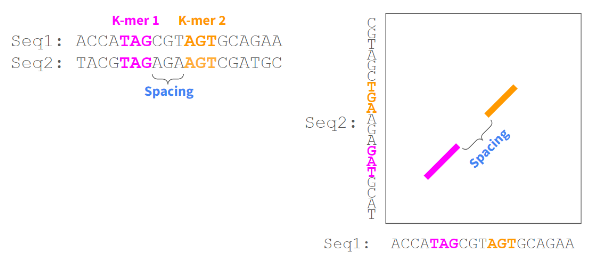

In [33]:
# Link kmers. We input a sequences, kmer size, a kmer index, and the maximum spacing between kmers
# We r gonna output a k-mer chain represented as a tuple of integers.
def link_kmers(query: str, k: int, the_index: dict, max_spacing: int) -> Tuple[int, int, int] | None:
    # YOUR CODE HERE
    query_index = build_simple_index(query, k)

    overlapped_info = []
    for kmer, pos_qlst in query_index.items():
        if the_index.get(kmer) is not None:
            for pos_q in pos_qlst:
                for pos_r in the_index[kmer]:
                    info = (kmer, pos_q, pos_r)
                    overlapped_info.append(info)
    
    if len(overlapped_info) < 2:
        return None

    df = pd.DataFrame(overlapped_info).rename(columns = {0:'kmer', 1:'query_loc', 2:'ref_loc'})
    df = df.sort_values(by = ['ref_loc']).reset_index().drop(['index'], axis = 1)
    
    for i in range(len(df)):
        df_proc = df.copy()
        loc_ref_lb = df_proc.iloc[i]['ref_loc'] + k
        loc_ref_ub = df_proc.iloc[i]['ref_loc'] + k + max_spacing
        loc_query_lb = df_proc.iloc[i]['query_loc'] + k
        loc_query_ub = df_proc.iloc[i]['query_loc'] + k + max_spacing
        
        df_ref_filt = df_proc[(df_proc['ref_loc'] > loc_ref_lb) & (df_proc['ref_loc'] <= loc_ref_ub)]
        df_filtered = df_ref_filt[(df_ref_filt['query_loc'] > loc_query_lb) & (df_ref_filt['query_loc'] <= loc_query_ub)]
        if len(df_filtered) != 0:
            return (df_proc.iloc[i]['query_loc'], df_proc.iloc[i]['ref_loc'], df_filtered.iloc[0]['ref_loc'] - loc_ref_lb)
    return None

In [35]:
# This function copes with a chain of 2 k-mer matches which requires ungapped alignment to fill the gap to extend either direction to form a HSP

def ungapped_extension(seq1: str, seq2: str, chain: Tuple, k: int, max_mismatches: int) -> Tuple[int, int, int] | None:
    # YOUR CODE HERE
    start_pos_s1 = chain[0]; start_pos_s2 = chain[1]
    end_pos_s1 = chain[0] + k*2 + chain[2] - 1
    end_pos_s2 = chain[1] + k*2 + chain[2] - 1

    # check internal
    diff = 0
    for i in range(chain[2]):
        if seq1[chain[0] + k + i] != seq2[chain[1] + k + i]:
            diff += 1
        if diff > max_mismatches:
            return None

    max_mismatches -= diff
    
    # check the left
    start_pos_s1 = chain[0]; start_pos_s2 = chain[1]
    mismatches = 0
    while mismatches <= max_mismatches and (start_pos_s1 >= 0 or start_pos_s2 >= 0):
        if seq1[start_pos_s1] != seq2[start_pos_s2]:
            mismatches += 1
            if mismatches > max_mismatches:
                break
        start_pos_s1 -= 1; start_pos_s2 -= 1
    
    # check the right
    end_pos_s1 = chain[0] + k*2 + chain[2] - 1
    end_pos_s2 = chain[1] + k*2 + chain[2] - 1
    mismatches = 0
    while mismatches <= max_mismatches and (end_pos_s1 < len(seq1) and end_pos_s2 < len(seq2)):
        if seq1[end_pos_s1] != seq2[end_pos_s2]:
            mismatches += 1
            if mismatches > max_mismatches:
                break
        end_pos_s1 += 1; end_pos_s2 += 1
    
    lenth = (end_pos_s1 - 1) - (start_pos_s1 + 1) + 1
    return (start_pos_s1 + 1, start_pos_s2 + 1, lenth)

In [37]:
# Local alignment
def local_alignment(seq1: str, seq2: str, hsp: Tuple[int, int, int], min_score: int) -> Bio.Align.Alignment | None:
    # YOUR CODE HERE
    aligner = Bio.Align.PairwiseAligner()
    aligner.mode = 'local'    
    start_ref = max((hsp[1] - hsp[0]), 0)
    end_ref = hsp[1] + hsp[2] + (len(seq1) - hsp[2] - (hsp[1] - start_ref))
    
    alignments = aligner.align(seq1, seq2[start_ref:end_ref])
    if alignments[0].score < min_score:
        return None
    return alignments[0]

In [39]:
# Working on the seed extend alignment
def identify_plastic_degrading_proteins(queries_filepath: str, reference_filepath: str, k: int) -> list[Tuple]:
    # YOUR CODE HERE
    prot_unknown = list(load_proteins(queries_filepath))
    prot_db = list(load_proteins(reference_filepath))
    match_lst = []
    for i in range(len(prot_unknown)):
        for j in range(len(prot_db)):
            the_index = build_simple_index(prot_db[j][1], k)
            chain = link_kmers(query = prot_unknown[i][1], k = k, the_index = the_index, max_spacing = MAX_SPACING)
            if chain is not None:
                hsp_pos = ungapped_extension(seq1 = prot_unknown[i][1], seq2 = prot_db[j][1], chain = chain, k = k, max_mismatches = MAX_MISMATCHES)
                if hsp_pos is not None:
                    if local_alignment(seq1 = prot_unknown[i][1], seq2 = prot_db[j][1], hsp = hsp_pos, min_score = MIN_ALIGN_SCORE) is not None:
                        info = (prot_unknown[i][0], prot_db[j][0])
                        match_lst.append(info)

    return match_lst    